# A Primer on Bayesian Methods for Multilevel Modeling

Hierarchical or multilevel modeling is a generalization of regression modeling.

*Multilevel models* are regression models in which the constituent model parameters are given **probability models**. This implies that model parameters are allowed to **vary by group**.

Observational units are often naturally **clustered**. Clustering induces dependence between observations, despite random sampling of clusters and random sampling within clusters.

A *hierarchical model* is a particular multilevel model where parameters are nested within one another.

Some multilevel structures are not hierarchical. 

* e.g. "country" and "year" are not nested, but may represent separate, but overlapping, clusters of parameters

We will motivate this topic using an environmental epidemiology example.

### Example: Radon contamination (Gelman and Hill 2006)

Let's revisit the radon contamination example from the previous section. For hierarchical modeling, we will use more of the data; we will focus on modeling radon levels in Minnesota. The EPA did the radon study  in 80,000 houses. There were two important predictors:

* measurement in basement or first floor (radon higher in basements)
* county uranium level (positive correlation with radon levels)

The hierarchy in this example is households within county. 

### Data organization

First, we import the data from a local file, and extract Minnesota's data.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_context('notebook')
import warnings
warnings.simplefilter("ignore")

# Import radon data
radon_data = pd.read_csv('../data/radon.csv', index_col=0)

RANDOM_SEEDS = 20090425, 19700903

In [2]:
counties = radon_data.county.unique()
n_counties = counties.shape[0]
county = radon_data.county_code.values
log_radon = radon_data.log_radon.values
floor_measure = radon_data.floor.values
log_uranium = np.log(radon_data.Uppm.values)
county_lookup = dict(zip(counties, np.arange(n_counties)))

Distribution of radon levels in MN (log scale):

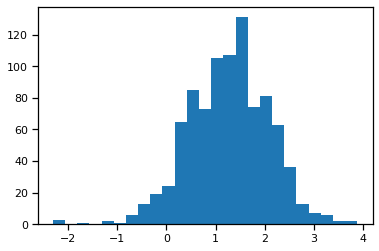

In [3]:
radon_data.activity.apply(lambda x: np.log(x+0.1)).hist(bins=25, grid=False);

## Conventional approaches

The two conventional alternatives to modeling radon exposure represent the two extremes of the bias-variance tradeoff:

***Complete pooling***: 

Treat all counties the same, and estimate a single radon level.

$$y_i = \alpha + \beta x_i + \epsilon_i$$

***No pooling***:

Model radon in each county independently.

$$y_i = \alpha_{j[i]} + \beta x_i + \epsilon_i$$

where $j = 1,\ldots,85$

The errors $\epsilon_i$ may represent measurement error, temporal within-house variation, or variation among houses.

Here are the point estimates of the slope and intercept for the complete pooling model:

In [4]:
from pymc3 import Model, sample, Normal, HalfCauchy, Uniform

floor = radon_data.floor.values
log_radon = radon_data.log_radon.values

with Model() as pooled_model:
    
    β = Normal('β', 0, sigma=10, shape=2)
    σ = HalfCauchy('σ', 5)
    
    θ = β[0] + β[1]*floor
    
    y = Normal('y', θ, sigma=σ, observed=log_radon)
    

In [ ]:
with pooled_model:
    pooled_trace = sample(1000, tune=1000, cores=2, random_seed=RANDOM_SEEDS)

In [ ]:
b0, m0 = pooled_trace['β'].mean(axis=0)

In [ ]:
plt.scatter(radon_data.floor, np.log(radon_data.activity+0.1))
xvals = np.linspace(-0.2, 1.2)
plt.plot(xvals, m0*xvals+b0, 'r--');

Estimates of county radon levels for the unpooled model:

In [ ]:
with Model() as unpooled_model:
    
    β0 = Normal('β0', 0, sigma=10, shape=n_counties)
    β1 = Normal('β1', 0, sigma=10)
    σ = HalfCauchy('σ', 5)
    
    θ = β0[county] + β1*floor
    
    y = Normal('y', θ, sigma=σ, observed=log_radon)
    

In [ ]:
with unpooled_model:
    unpooled_trace = sample(1000, tune=1000, cores=2, random_seed=RANDOM_SEEDS)

In [ ]:
from arviz import plot_forest

_, (ax,) = plot_forest(unpooled_trace, var_names=['β0'])
ax.set_yticklabels([""]);

In [ ]:
unpooled_estimates = pd.Series(unpooled_trace['β0'].mean(axis=0), index=counties)
unpooled_se = pd.Series(unpooled_trace['β0'].std(axis=0), index=counties)

We can plot the ordered estimates to identify counties with high radon levels:

In [ ]:
order = unpooled_estimates.sort_values().index

plt.scatter(range(len(unpooled_estimates)), unpooled_estimates[order])
for i, m, se in zip(range(len(unpooled_estimates)), unpooled_estimates[order], unpooled_se[order]):
    plt.plot([i,i], [m-se, m+se], 'b-')
plt.xlim(-1,86); plt.ylim(-1,4)
plt.ylabel('Radon estimate');plt.xlabel('Ordered county');

Here are visual comparisons between the pooled and unpooled estimates for a subset of counties representing a range of sample sizes.

In [ ]:
sample_counties = ('LAC QUI PARLE', 'AITKIN', 'KOOCHICHING', 
                    'DOUGLAS', 'CLAY', 'STEARNS', 'RAMSEY', 'ST LOUIS')

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
m = unpooled_trace['β1'].mean()
for i,c in enumerate(sample_counties):
    y = radon_data.log_radon[radon_data.county==c]
    x = radon_data.floor[radon_data.county==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)
    
    # No pooling model
    b = unpooled_estimates[c]
    
    # Plot both models and data
    xvals = np.linspace(-0.2, 1.2)
    axes[i].plot(xvals, m*xvals+b)
    axes[i].plot(xvals, m0*xvals+b0, 'r--')
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(['basement', 'floor'])
    axes[i].set_ylim(-1, 3)
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel('log radon level')

Neither of these models are satisfactory:

* if we are trying to identify high-radon counties, pooling is useless
* we do not trust extreme unpooled estimates produced by models using few observations

## Multilevel and hierarchical models

When we pool our data, we imply that they are sampled from the same model. This ignores any variation among sampling units (other than sampling variance):

![pooled](images/pooled_model.png)

When we analyze data unpooled, we imply that they are sampled independently from separate models. At the opposite extreme from the pooled case, this approach claims that differences between sampling units are to large to combine them:

![unpooled](images/unpooled_model.png)

In a hierarchical model, parameters are viewed as a sample from a population distribution of parameters. Thus, we view them as being neither entirely different or exactly the same. This is ***parital pooling***.

![hierarchical](images/partially_pooled_model.png)

We can use PyMC to easily specify multilevel models, and fit them using Markov chain Monte Carlo.

## Partial pooling model

The simplest partial pooling model for the household radon dataset is one which simply estimates radon levels, without any predictors at any level. A partial pooling model represents a compromise between the pooled and unpooled extremes, approximately a weighted average (based on sample size) of the unpooled county estimates and the pooled estimates.

$$\hat{\alpha} \approx \frac{(n_j/\sigma_y^2)\bar{y}_j + (1/\sigma_{\alpha}^2)\bar{y}}{(n_j/\sigma_y^2) + (1/\sigma_{\alpha}^2)}$$

Estimates for counties with smaller sample sizes will shrink towards the state-wide average.

Estimates for counties with larger sample sizes will be closer to the unpooled county estimates.

In [ ]:
with Model() as partial_pooling:
    
    # Priors
    μ_a = Normal('μ_a', mu=0., sigma=10)
    σ_a = HalfCauchy('σ_a', 5)
    
    # Random intercepts
    a = Normal('a', mu=μ_a, sigma=σ_a, shape=n_counties)
    
    # Model error
    σ_y = HalfCauchy('σ_y',5)
    
    # Expected value
    y_hat = a[county]
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sigma=σ_y, observed=log_radon)
    

In [ ]:
with partial_pooling:
    partial_pooling_trace = sample(1000, tune=1000, cores=2, random_seed=RANDOM_SEEDS)

In [ ]:
sample_trace = partial_pooling_trace['a']

fig, axes = plt.subplots(1, 2, figsize=(14,6), sharex=True, sharey=True)
n_samples, n_counties = sample_trace.shape
jitter = np.random.normal(scale=0.1, size=n_counties)

n_county = radon_data.groupby('county')['county_code'].count()
unpooled_means = radon_data.groupby('county')['log_radon'].mean()
unpooled_sd = radon_data.groupby('county')['log_radon'].std()
unpooled = pd.DataFrame({'n':n_county, 'm':unpooled_means, 'sd':unpooled_sd})
unpooled['se'] = unpooled.sd/np.sqrt(unpooled.n)

axes[0].plot(unpooled.n + jitter, unpooled.m, 'b.')
for j, row in zip(jitter, unpooled.iterrows()):
    name, dat = row
    axes[0].plot([dat.n+j,dat.n+j], [dat.m-dat.se, dat.m+dat.se], 'b-')
axes[0].set_xscale('log')
axes[0].hlines(sample_trace.mean(), 0.9, 100, linestyles='--')

        
n_samples, n_counties = sample_trace.shape
means = sample_trace.mean(axis=0)
sd = sample_trace.std(axis=0)
axes[1].scatter(n_county.values + jitter, means)
axes[1].set_xscale('log')
axes[1].set_xlim(1,100)
axes[1].set_ylim(0, 3)
axes[1].hlines(sample_trace.mean(), 0.9, 100, linestyles='--')
for j,n,m,s in zip(jitter, n_county.values, means, sd):
    axes[1].plot([n+j]*2, [m-s, m+s], 'b-');

Notice the difference between the unpooled and partially-pooled estimates, particularly at smaller sample sizes. The former are both more extreme and more imprecise.

## Varying intercept model

This model allows intercepts to vary across county, according to a random effect.

$$y_i = \alpha_{j[i]} + \beta x_{i} + \epsilon_i$$

where

$$\epsilon_i \sim N(0, \sigma_y^2)$$

and the intercept random effect:

$$\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$$

As with the the “no-pooling” model, we set a separate intercept for each county, but rather than fitting separate least squares regression models for each county, multilevel modeling **shares strength** among counties, allowing for more reasonable inference in counties with little data.

In [ ]:
with Model() as varying_intercept:
    
    # Priors
    μ_a = Normal('μ_a', mu=0., sigma=10)
    σ_a = HalfCauchy('σ_a', 5)
    
    
    # Random intercepts
    a = Normal('a', mu=μ_a, sigma=σ_a, shape=n_counties)
    # Common slope
    b = Normal('b', mu=0., sigma=10)
    
    # Model error
    sd_y = HalfCauchy('sd_y', 5)
    
    # Expected value
    y_hat = a[county] + b * floor_measure
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sigma=sd_y, observed=log_radon)
    

In [ ]:
with varying_intercept:
    varying_intercept_trace = sample(1000, tune=1000, cores=2, random_seed=RANDOM_SEEDS)

In [ ]:
fig, (ax,) = plot_forest(varying_intercept_trace, var_names=['a'])
ax.set_yticklabels([""]);

In [ ]:
from arviz import plot_posterior

plot_posterior(varying_intercept_trace, var_names=['σ_a', 'b']);

The estimate for the `floor` coefficient is approximately -0.66, which can be interpreted as houses without basements having about half ($\exp(-0.66) = 0.52$) the radon levels of those with basements, after accounting for county.

In [ ]:
from pymc3 import summary

summary(varying_intercept_trace, var_names=['b'])

In [ ]:
xvals = np.arange(2)
bp = varying_intercept_trace[a].mean(axis=0)
mp = varying_intercept_trace[b].mean()
for bi in bp:
    plt.plot(xvals, mp*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1,1.1);

It is easy to show that the partial pooling model provides more objectively reasonable estimates than either the pooled or unpooled models, at least for counties with small sample sizes.

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
for i,c in enumerate(sample_counties):
    
    # Plot county data
    y = radon_data.log_radon[radon_data.county==c]
    x = radon_data.floor[radon_data.county==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)
    
    # No pooling model
    m,b = unpooled_estimates[['floor', c]]
    
    xvals = np.linspace(-0.2, 1.2)
    # Unpooled estimate
    axes[i].plot(xvals, m*xvals+b)
    # Pooled estimate
    axes[i].plot(xvals, m0*xvals+b0, 'r--')
    # Partial pooling esimate
    axes[i].plot(xvals, mp*xvals+bp[county_lookup[c]], 'k:')
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(['basement', 'floor'])
    axes[i].set_ylim(-1, 3)
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel('log radon level');

## Varying slope model

Alternatively, we can posit a model that allows the counties to vary according to how the location of measurement (basement or floor) influences the radon reading.

$$y_i = \alpha + \beta_{j[i]} x_{i} + \epsilon_i$$


In [ ]:
with Model() as varying_slope:
    
    # Priors
    μ_b = Normal('μ_b', mu=0., sigma=10)
    σ_b = HalfCauchy('σ_b', 5)
    
    # Common intercepts
    a = Normal('a', mu=0., sigma=10)
    # Random slopes
    b = Normal('b', mu=μ_b, sigma=σ_b, shape=n_counties)
    
    # Model error
    σ_y = HalfCauchy('σ_y',5)
    
    # Expected value
    y_hat = a + b[county] * floor_measure
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sigma=σ_y, observed=log_radon)
    

In [ ]:
with varying_slope:
    varying_slope_trace = sample(1000, tune=1000, cores=2, random_seed=RANDOM_SEEDS)

In [ ]:
_, (ax,) = plot_forest(varying_slope_trace, var_names=['b'])
ax.set_yticklabels([""]);

In [ ]:
xvals = np.arange(2)
b = varying_slope_trace['a'].mean()
m = varying_slope_trace['b'].mean(axis=0)
for mi in m:
    plt.plot(xvals, mi*xvals + b, 'bo-', alpha=0.4)
plt.xlim(-0.2, 1.2);

## Non-centered Parameterization

The partial pooling models specified above uses a **centered** parameterization of the slope random effect. That is, the individual county effects are distributed around a county mean, with a spread controlled by the hierarchical standard deviation parameter. As the preceding plot reveals, this constraint serves to **shrink** county estimates toward the overall mean, to a degree proportional to the county sample size. This is exactly what we want, and the model appears to fit well--the Gelman-Rubin statistics are exactly 1.

But, on closer inspection, there are signs of trouble. Specifically, let's look at the trace of the random effects, and their corresponding standard deviation:

In [ ]:
fig, axs = plt.subplots(nrows=2)
axs[0].plot(varying_slope_trace.get_values('σ_b', chains=0), alpha=.5);
axs[0].set(ylabel='σ_b');
axs[1].plot(varying_slope_trace.get_values('b', chains=0), alpha=.05);
axs[1].set(ylabel='b');

Notice that when the chain reaches the lower end of the parameter space for $\sigma_b$, it appears to get "stuck" and the entire sampler, including the random slopes `b`, mixes poorly. 

Jointly plotting the random effect variance and one of the individual random slopes demonstrates what is going on.

In [ ]:
x = pd.Series(varying_slope_trace['b'][:, 10], name='slope')
y = pd.Series(varying_slope_trace['σ_b'], name='slope group variance')

jp = sns.jointplot(x, y, ylim=(0, .7), stat_func=None)

When the group variance is small, this implies that the individual random slopes are themselves close to the group mean. This results in a *funnel*-shaped relationship between the samples of group variance and any of the slopes (particularly those with a smaller sample size). 

In itself, this is not a problem, since this is the behavior we expect. However, if the sampler is tuned for the wider (unconstrained) part of the parameter space, it has trouble in the areas of higher curvature. The consequence of this is that the neighborhood close to the lower bound of $\sigma_b$ is sampled poorly; indeed, in our chain it is not sampled at all below 0.1. The result of this will be biased inference.

Now that we've spotted the problem, what can we do about it? The best way to deal with this issue is to reparameterize our model. Notice the random slopes in this version:

In [ ]:
from pymc3 import Deterministic

with Model() as varying_slope_noncentered:
    
    # Priors
    μ_b = Normal('μ_b', mu=0., sigma=10)
    σ_b = HalfCauchy('σ_b', 5)
    
    # Common intercepts
    a = Normal('a', mu=0., sigma=10)
    
    # Non-centered random slopes
    # Centered: b = Normal('b', μ_b, sigma=σ_b, shape=counties)
    υ = Normal('υ', mu=0, sigma=1, shape=n_counties)
    b = Deterministic("b", μ_b + υ * σ_b)
    
    # Model error
    σ_y = HalfCauchy('σ_y',5)
    
    # Expected value
    y_hat = a + b[county] * floor_measure
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sigma=σ_y, observed=log_radon)
    

This is a **non-centered** parameterization. By this, we mean that the random deviates are no longer explicitly modeled as being centered on $\mu_b$. Instead, they are independent standard normals $\upsilon$, which are then scaled by the appropriate value of $\sigma_b$, before being location-transformed by the mean.

This model samples much better.

In [ ]:
with varying_slope_noncentered:
    noncentered_trace = sample(1000, tune=2000, cores=2)

Notice that the bottlenecks in the traces are gone.

In [ ]:
fig, axs = plt.subplots(nrows=2)
axs[0].plot(noncentered_trace.get_values('σ_b', chains=0), alpha=.5);
axs[0].set(ylabel='σ_b');
axs[1].plot(noncentered_trace.get_values('b', chains=0), alpha=.5);
axs[1].set(ylabel='b');

And, we are now fully exploring the support of the posterior.

In [ ]:
x = pd.Series(noncentered_trace['b'][:, 75], name='slope')
y = pd.Series(noncentered_trace['σ_b'], name='slope group variance')

sns.jointplot(x, y, ylim=(0, .7), stat_func=None);

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
plot_posterior(varying_slope_trace, var_names=['σ_b'], ax=ax1, color='LightSeaGreen')
plot_posterior(noncentered_trace, var_names=['σ_b'], ax=ax2, color='LightSeaGreen')
ax1.set_title('Centered (top) and non-centered (bottom)');

## Varying intercept and slope model

The most general model allows both the intercept and slope to vary by county:

$$y_i = \alpha_{j[i]} + \beta_{j[i]} x_{i} + \epsilon_i$$


In [ ]:
with Model() as varying_intercept_slope:
    
    # Priors
    mu_a = Normal('mu_a', mu=0., sigma=10)
    sigma_a = HalfCauchy('sigma_a', 5)
    
    mu_b = Normal('mu_b', mu=0., sigma=10)
    sigma_b = HalfCauchy('sigma_b', 5)
    
    # Random intercepts
    a = Normal('a', mu=mu_a, sigma=sigma_a, shape=n_counties)
    # Random slopes
    b = Normal('b', mu=mu_b, sigma=sigma_b, shape=n_counties)
    
    # Model error
    sigma_y = Uniform('sigma_y', lower=0, upper=100)
    
    # Expected value
    y_hat = a[county] + b[county] * floor_measure
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sigma=sigma_y, observed=log_radon)

In [ ]:
with varying_intercept_slope:
    varying_intercept_slope_trace = sample(1000, tune=1000, cores=2, random_seed=RANDOM_SEEDS)

In [ ]:
plot_forest(varying_intercept_slope_trace, var_names=['a','b']);

In [ ]:
xvals = np.arange(2)
b = varying_intercept_slope_trace['a'].mean(axis=0)
m = varying_intercept_slope_trace['b'].mean(axis=0)
for bi,mi in zip(b,m):
    plt.plot(xvals, mi*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1, 1.1);

### Exercise

Reparameterize the `varying_intercept_slope` model to be non-centered, and compare the resulting parameter estimates.

In [ ]:
# Write your answer here

## Adding group-level predictors

A primary strength of multilevel models is the ability to handle predictors on multiple levels simultaneously. If we consider the varying-intercepts model above:

$$y_i = \alpha_{j[i]} + \beta x_{i} + \epsilon_i$$

we may, instead of a simple random effect to describe variation in the expected radon value, specify another regression model with a county-level covariate. Here, we use the county uranium reading $u_j$, which is thought to be related to radon levels:

$$\alpha_j = \gamma_0 + \gamma_1 u_j + \zeta_j$$

$$\zeta_j \sim N(0, \sigma_{\alpha}^2)$$

Thus, we are now incorporating a house-level predictor (floor or basement) as well as a county-level predictor (uranium).

Note that the model has both indicator variables for each county, plus a county-level covariate. In classical regression, this would result in collinearity. In a multilevel model, the partial pooling of the intercepts towards the expected value of the group-level linear model avoids this.

Group-level predictors also serve to reduce group-level variation $\sigma_{\alpha}$. An important implication of this is that the group-level estimate induces stronger pooling.

In [ ]:
from pymc3 import Deterministic

with Model() as hierarchical_intercept:
    
    # Priors
    σ_a = HalfCauchy('σ_a', 5)
    
    # County uranium model
    γ_0 = Normal('γ_0', mu=0., sigma=10)
    γ_1 = Normal('γ_1', mu=0., sigma=10)
    
    
    # Uranium model for intercept
    μ_a = γ_0 + γ_1*log_uranium
    # County variation not explained by uranium
    ϵ_a = Normal('ϵ_a', mu=0, sigma=1, shape=n_counties)
    a = Deterministic('a', μ_a + σ_a*ϵ_a[county])
    
    # Common slope
    b = Normal('b', mu=0., sigma=10)
    
    # Model error
    σ_y = Uniform('σ_y', lower=0, upper=100)
    
    # Expected value
    y_hat = a + b * floor_measure
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sigma=σ_y, observed=log_radon)
    

In [ ]:
with hierarchical_intercept:
    hierarchical_intercept_trace = sample(1000, tune=1000, cores=2, random_seed=RANDOM_SEEDS)

In [ ]:
a_means = hierarchical_intercept_trace['a'].mean(axis=0)
plt.scatter(log_uranium, a_means)
g0 = hierarchical_intercept_trace['γ_0'].mean()
g1 = hierarchical_intercept_trace['γ_1'].mean()
xvals = np.linspace(-1, 0.8)
plt.plot(xvals, g0+g1*xvals, 'k--')
plt.xlim(-1, 0.8)

a_se = hierarchical_intercept_trace['a'].std(axis=0)
for ui, m, se in zip(log_uranium, a_means, a_se):
    plt.plot([ui,ui], [m-se, m+se], 'b-')
plt.xlabel('County-level uranium'); plt.ylabel('Intercept estimate');

The standard errors on the intercepts are narrower than for the partial-pooling model without a county-level covariate.

### Correlations among levels

In some instances, having predictors at multiple levels can reveal correlation between individual-level variables and group residuals. We can account for this by including the average of the individual predictors as a covariate in the model for the group intercept.

$$\alpha_j = \gamma_0 + \gamma_1 u_j + \gamma_2 \bar{x} + \zeta_j$$

These are broadly referred to as ***contextual effects***.

In [ ]:
# Create new variable for mean of floor across counties
xbar = radon_data.groupby('county')['floor'].mean().rename(county_lookup).values

In [ ]:
with Model() as contextual_effect:
    
    # Priors
    σ_a = HalfCauchy('σ_a', 5)
    
    # County uranium model for slope
    γ = Normal('γ', mu=0., sigma=10, shape=3)
    
    # Uranium model for intercept
    μ_a = Deterministic('μ_a', γ[0] + γ[1]*log_uranium + γ[2]*xbar[county])

    # County variation not explained by uranium
    ϵ_a = Normal('ϵ_a', mu=0, sigma=1, shape=n_counties)
    a = Deterministic('a', μ_a + σ_a*ϵ_a[county])

    # Common slope
    b = Normal('b', mu=0., sigma=10)
    
    # Model error
    σ_y = Uniform('σ_y', lower=0, upper=100)
    
    # Expected value
    y_hat = a + b * floor_measure
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sigma=σ_y, observed=log_radon)
    

In [ ]:
with contextual_effect:
    contextual_effect_trace = sample(1000, tune=1000, cores=2, random_seed=RANDOM_SEEDS)

In [ ]:
plot_forest(contextual_effect_trace, var_names=['γ']);

In [ ]:
summary(contextual_effect_trace, var_names=['γ'])

So, we might infer from this that counties with higher proportions of houses without basements tend to have higher baseline levels of radon. Perhaps this is related to the soil type, which in turn might influence what type of structures are built.

### Prediction

Gelman (2006) used cross-validation tests to check the prediction error of the unpooled, pooled, and partially-pooled models

**root mean squared cross-validation prediction errors**:

* unpooled = 0.86
* pooled = 0.84
* multilevel = 0.79

There are two types of prediction that can be made in a multilevel model:

1. a new individual within an existing group
2. a new individual within a new group

For example, if we wanted to make a prediction for a new house with no basement in St. Louis county, we just need to sample from the radon model with the appropriate intercept.

In [ ]:
county_lookup['ST LOUIS']

That is, 

$$\tilde{y}_i \sim N(\alpha_{69} + \beta (x_i=1), \sigma_y^2)$$

This is simply a matter of adding a single additional line in PyMC:

In [ ]:
with Model() as contextual_pred:
    
    # Priors
    σ_a = HalfCauchy('σ_a', 5)
    
    # County uranium model for slope
    γ = Normal('γ', mu=0., sigma=10, shape=3)
    
    # Uranium model for intercept
    μ_a = Deterministic('μ_a', γ[0] + γ[1]*log_uranium + γ[2]*xbar[county])

    # County variation not explained by uranium
    ϵ_a = Normal('ϵ_a', mu=0, sigma=1, shape=n_counties)
    a = Deterministic('a', μ_a + σ_a*ϵ_a[county])

    # Common slope
    b = Normal('b', mu=0., sigma=10)
    
    # Model error
    σ_y = Uniform('σ_y', lower=0, upper=100)
    
    # Expected value
    y_hat = a + b * floor_measure
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sigma=σ_y, observed=log_radon)
    
    # St Louis county prediction
    stl_pred = Normal('stl_pred', mu=a[69] + b, sigma=σ_y)
    

In [ ]:
with contextual_pred:
    contextual_pred_trace = sample(2000, tune=1000, cores=2, random_seed=RANDOM_SEEDS)

In [ ]:
plot_posterior(contextual_pred_trace, var_names=['stl_pred']);

## Exercise

How would we make a prediction from a new county (*e.g.* one not included in this dataset)?

In [ ]:
# Write your answer here

## Benefits of Multilevel Models

- Accounting for natural hierarchical structure of observational data
- Estimation of coefficients for (under-represented) groups
- Incorporating individual- and group-level information when estimating group-level coefficients
- Allowing for variation among individual-level coefficients across groups


## Exercise: Cancer Rate Estimation

[Tsutakawa et al. (1985)](http://onlinelibrary.wiley.com/doi/10.1002/sim.4780040210/abstract) provides mortality data for stomach cancer among men aged 45-64 in several cities in Missouri. The file `cancer.csv` contains deaths $y_i$ and subjects at risk $n_i$ for 20 cities from this dataset.

In [6]:
import pandas as pd

cancer = pd.read_csv('../data/cancer.csv')
cancer

,y,n
0,0,1083
1,0,855
2,2,3461
3,0,657
4,1,1208
5,1,1025
6,0,527
7,2,1668
8,1,583
9,3,582


If we use a simple binomial model, which assumes independent samples from a binomial distribution with probability of mortality $p$, we can use MLE to obtain an estimate of this probability.

In [8]:
# Write your answer here
cancer['y'].sum()/cancer['n'].sum()

0.0009933126276616582

In [9]:
from pymc3 import Binomial

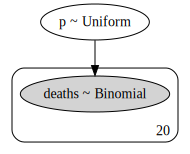

In [45]:
with Model() as cancer_estimator:
    p = Uniform('p', lower=0, upper=1)
    deaths = Binomial('deaths', n=cancer['n'], p=p, observed=cancer['y'])

from pymc3 import model_to_graphviz

model_to_graphviz(cancer_estimator)

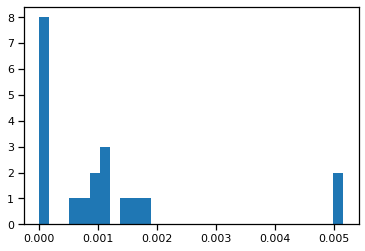

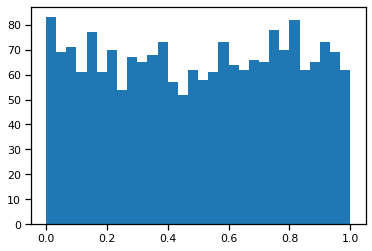

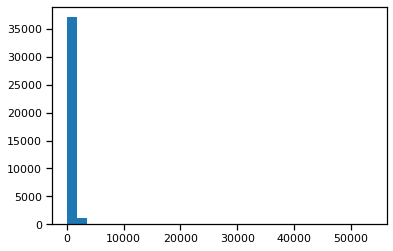

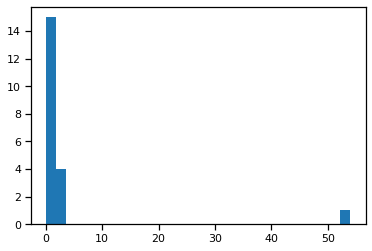

In [46]:
from pymc3 import sample_prior_predictive

with cancer_estimator:
    prior_sample = sample_prior_predictive(2000)

plt.figure()
plt.hist(cancer['y']/cancer['n'], bins=30);
plt.figure()
plt.hist(prior_sample['p'].ravel(), bins=30);
plt.figure()
plt.hist(prior_sample['deaths'].ravel(), bins=30);
plt.figure()
plt.hist(cancer['y'], bins=30);

In [47]:
from pymc3 import sample

with cancer_estimator:
    samples = sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:01<00:00, 7369.03draws/s]


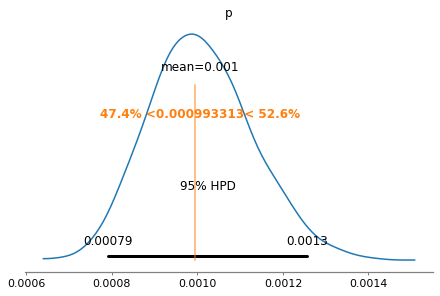

In [48]:
from arviz import plot_posterior

plot_posterior(samples, var_names=['p'], ref_val=cancer['y'].sum()/cancer['n'].sum(), credible_interval=0.95, kind='kde');

In [39]:
cancer_estimator

In [49]:
from pymc3 import HalfStudentT

with Model() as cancer_partialpool:
    alpha = HalfStudentT('alpha', )
    p = Beta('p', lower=0, upper=1)
    deaths = Binomial('deaths', n=cancer['n'], p=p, observed=cancer['y'])

from pymc3 import model_to_graphviz

model_to_graphviz(cancer_estimator)

TypeError: __new__() missing 1 required positional argument: 'name'

In [15]:
from pymc3 import Beta

Beta()


TypeError: __new__() missing 1 required positional argument: 'name'

---
## References

Gelman, A., & Hill, J. (2006). Data Analysis Using Regression and Multilevel/Hierarchical Models (1st ed.). Cambridge University Press.

Betancourt, M. J., & Girolami, M. (2013). Hamiltonian Monte Carlo for Hierarchical Models.

Gelman, A. (2006). Multilevel (Hierarchical) modeling: what it can and cannot do. Technometrics, 48(3), 432–435.